# PyTorch Model Inference

In [1]:
from fastai.vision.all import *

In [2]:
from os import path
import torch
import torchvision
torch.cuda.is_available()

True

In [3]:
torch.__version__

'2.8.0+cu128'

## Configuration

In [4]:
model_name = 'p-tebcwh-batch-norm-moderate-resnet50-noconv-unfrozen'
model_path = Path("/home/pedro/code/photo-editing/filternet/models")

arch = resnet50
bs=24

# Temperature range
maxKelvin = 10000
minKelvin = 4000

# Probability to drop filter params, or None
params_maskout = None

# pct_start for lr cycle
pct_start = 0.35

In [5]:
(model_path/(model_name + ".pth")).exists()

True

## Data

We will not be training the model. However, we need the data pipeline in order to instantiate a `learner` object with the `fastai` API.

**TODO**: can we do this simpler?

In [6]:
pixabay = Path(path.expanduser('~') + '/code/photo-editing/filternet/data')
path_targets = pixabay/'pixabay_saturated_resized'      # SATURATED dataset, flattened and resized to 460x460
path_crap_base = pixabay/'p_sat_tebcwh'   # Some random crappification data I had
path_crappified = path_crap_base/'crappified/01'

# Filenames in the validation dataset
path_valid_names = path_targets/'valid_names.json'

In [7]:
path_valid_names.exists()

True

In [8]:
from magicml.filters.all import *
RangedTemperatureFilter = partial(TemperatureFilter, maxKelvin=maxKelvin, minKelvin=minKelvin)

In [9]:
# Path of the target given the path of the crappified version

def get_target_path(path):
    target_path = path_targets/path.relative_to(path_crappified).name
    return target_path

## Augmentations and Transforms

In [10]:
fnames = get_image_files(path_targets)

In [11]:
image_normalization_stats = imagenet_stats
image_normalization_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [12]:
sq_size = 299 if arch == resnet50 else 224
wants_stretch = True
resize_method = 'squish' if wants_stretch else 'crop'
size = [sq_size, sq_size] if wants_stretch else sq_size

# This was None in the notebook, not sure if we should use it again
item_tfms = None  #Resize(item_resize, method=resize_method),

batch_tfms = [sRGBToLinear(),
              *aug_transforms(size=size, max_lighting=0, max_warp=0, max_zoom=0),
              Normalize.from_stats(*image_normalization_stats)]

We'll create the `DataBlock` and `DataLoaders` using the transforms defined in `filters-transforms`: conversion to linear space, plus filter transformations for the `x` images.

In [13]:
def read_valid_names():
    with open(path_valid_names, "r") as file:
        valid_names = json.loads(file.read())
    return valid_names

valid_names = read_valid_names()

In [14]:
data_block = DataBlock(blocks = (ImageBlock, ImageBlock),
                       get_items = get_image_files,
                       splitter = FuncSplitter(lambda item: item.name in valid_names),
                       get_y = get_target_path,
                       item_tfms = item_tfms,
                       batch_tfms = batch_tfms)

In [15]:
dsets = data_block.datasets(path_crappified)

Verify validation set is properly set up.

In [16]:
len(dsets.valid), len(dsets.train)

(977, 3908)

In [17]:
dsets.valid.items[0].name in valid_names

True

In [18]:
dsets.train[0]

(PILImage mode=RGB size=460x460, PILImage mode=RGB size=460x460)

<Axes: >

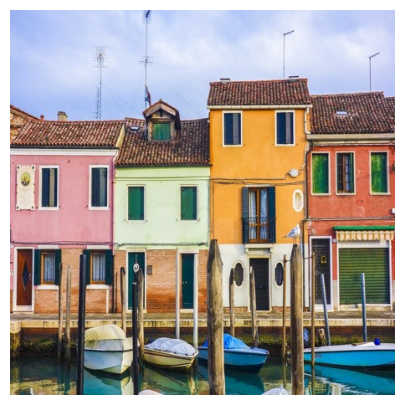

In [19]:
show_at(dsets.train, 0)

In [20]:
# data_block.summary(path_crappified)

In [21]:
#result
data = data_block.dataloaders(path_crappified, path=path_crappified, bs=bs)
data.after_batch

Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}
 -> sRGBToLinear -> Flip -- {'size': [299, 299], 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}
 -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}

## Create Model

In [22]:
filters_to_apply = [
    RangedTemperatureFilter,
    EVFilter,
    GradBrightness,
    GradContrast,
    GradShadows,
    GradHighlights,
]

# Order must match
filter_names=[
    'temperature',
    'ev',
    'brightness',
    'contrast',
    'shadows',
    'highlights'
]

num_vars = len(filters_to_apply)

Use a simple loss function instead of the real `FeatureLoss` that was actually used. We are not going to train the model.

In [23]:
base_loss = F.l1_loss
loss_func = base_loss

In [24]:
from magicml.model import *

Mixed-precision requires a GPU, so we don't convert `to_fp16()`.

**TODO**: we could now, but let's skip.

In [25]:
learn = filter_learner(data,
                       arch,
                       filters_to_apply,
                       loss_func=loss_func,
                       self_attention=False,
                       init_small=True,
                       dropout=params_maskout,
                       pre_linear_conv=False)

/home/pedro/code/photo-editing/.venv/lib/python3.12/site-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Initializing Linear(in_features=4096, out_features=512, bias=False) with values close to zero
Initializing Linear(in_features=512, out_features=6, bias=False) with values close to zero


**2025**: `summary()` failed about a missing `toTensor()`, not sure why. I commented it.

In [26]:
learn.summary()

FilterNet (Input shape: 24 x 3 x 299 x 299)
Layer (type)         Output Shape         Param #    Trainable 
                     24 x 64 x 150 x 150 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     24 x 64 x 75 x 75   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     24 x 256 x 75 x 75  
Conv2d                                    16384      False     
BatchNorm2d                         

In [27]:
# learn.model

There's an additional `FilterSet()` in `learn.model` after the sigmoid.

In [28]:
learn.model.model[-1]

fastai.layers.SigmoidRange(low=-1.0, high=1.0)

## Test inference

In [29]:
model_name, model_path

('p-tebcwh-batch-norm-moderate-resnet50-noconv-unfrozen',
 Path('/home/pedro/code/photo-editing/filternet/models'))

In [30]:
learn.model_dir = model_path

**2025**: we now need to add `weights_only=False` for pickle to succeed.

In [31]:
learn = learn.load(model_name, weights_only=False)
learn.freeze()

In [32]:
to_hook = learn.model.model

I don't remember why we need this.

In [33]:
class SigmoidHook(object):
    def __init__(self):
        self.sig_outputs = torch.tensor([])
        
    def __call__(self, m, i, o):
#         print(o.shape)
        self.sig_outputs = torch.stack([*self.sig_outputs, *o])
        return o

In [34]:
sigHook = SigmoidHook()
hook = Hook(to_hook, sigHook, is_forward=True, detach=False)

In [35]:
inference_model = learn

In [36]:
valid_sample = 0

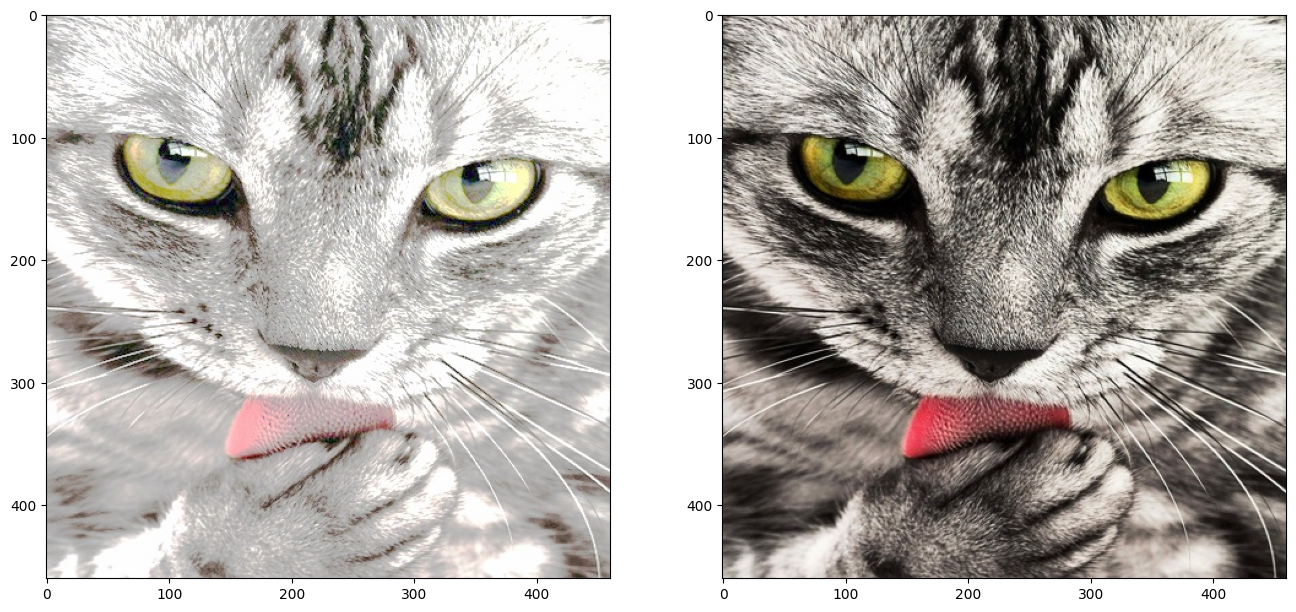

In [37]:
compare_images((data.valid_ds[valid_sample][0], data.valid_ds[valid_sample][1]))

In [38]:
test_prediction = inference_model.predict(data.valid_ds.items[valid_sample], with_input=True)
print(len(test_prediction))
[p.shape for p in test_prediction]

4


[torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299]),
 torch.Size([3, 299, 299])]

With `with_input=True`, we also have the decoded input as the first of the outputs.

In [39]:
decoded_input = test_prediction[0]
decoded_pred = test_prediction[1]

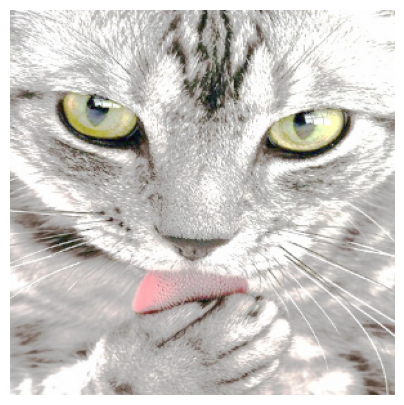

In [40]:
decoded_input.show();

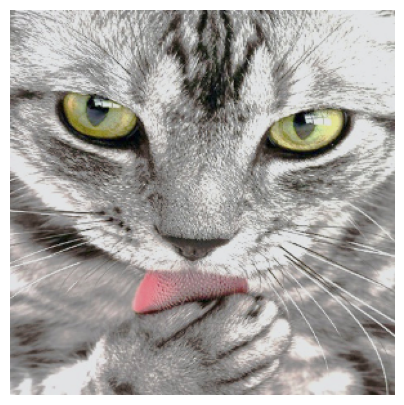

In [41]:
decoded_pred.show();

In [42]:
predicted_image = PILImage.create(decoded_pred)
predicted_image.size

(299, 299)

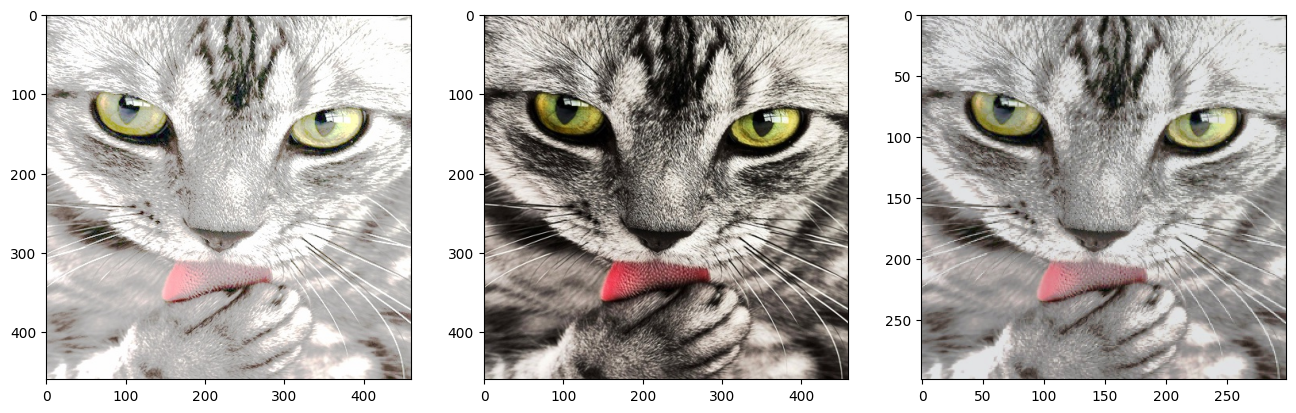

In [43]:
compare_images((data.valid_ds[valid_sample][0], data.valid_ds[valid_sample][1], predicted_image))

In [44]:
predicted_params = sigHook.sig_outputs[-1].cpu()
predicted_params

tensor([-0.0132, -0.0766, -0.2604,  0.1550, -0.7590, -0.3976])

Parameter order matches rendering order:

In [45]:
filters_to_apply

[functools.partial(<class 'magicml.filters.temperature.TemperatureFilter'>, maxKelvin=10000, minKelvin=4000),
 magicml.filters.core.EVFilter,
 magicml.filters.core.GradBrightness,
 magicml.filters.core.GradContrast,
 magicml.filters.core.GradShadows,
 magicml.filters.core.GradHighlights]

In [46]:
predicted_temperature, predicted_ev, predicted_brightness, predicted_contrast, predicted_shadows, predicted_highlights = predicted_params
print(f'temperature: {round(predicted_temperature.item(), 5)}, ev: {round(predicted_ev.item(), 5)}, brightness: {round(predicted_brightness.item(), 5)}, contrast: {round(predicted_contrast.item(), 5)}, highlights: {round(predicted_highlights.item(), 5)}, shadows: {round(predicted_shadows.item(), 5)}')

temperature: -0.01318, ev: -0.07661, brightness: -0.2604, contrast: 0.15502, highlights: -0.39759, shadows: -0.75897


In [47]:
import torchvision

# We could create a Pipeline here
def apply_to_image(image, params):
    image_transforms = torchvision.transforms.ToTensor()
    image_tensor = image_transforms(image)
    image_tensor = sRGB_to_linear(image_tensor)
    for f, p in zip(filters_to_apply, params):
        the_filter = f(intensities=[p])
        image_tensor = the_filter(image_tensor)
    image_tensor = linear_to_sRGB(image_tensor)
    return torchvision.transforms.ToPILImage()(image_tensor.type(torch.float))

def apply_to_item(path, params):
    image = Image.open(path)
    return apply_to_image(image, params)

## Test real images

In [48]:
test_path = Path(os.path.expanduser('~') + '/code/photo-editing/filternet/magic-ml-imac/model-tester/test_images')
image_list = get_image_files(test_path)
len(image_list)

293

In [49]:
from magicml.utils import *

I don't know where this `downsample()` method is coming from, probably `fastai`.

In [50]:
Image.open(image_list[0]).downsample().size

(460, 460)

In [51]:
# Downsample to 460x460, then let the model transforms resize to 224x224
def predict(path):
    image = Image.open(path).downsample()
    prediction = inference_model.predict(image)
    return PILImage.create(prediction[0])

In [52]:
img_to_test = 30

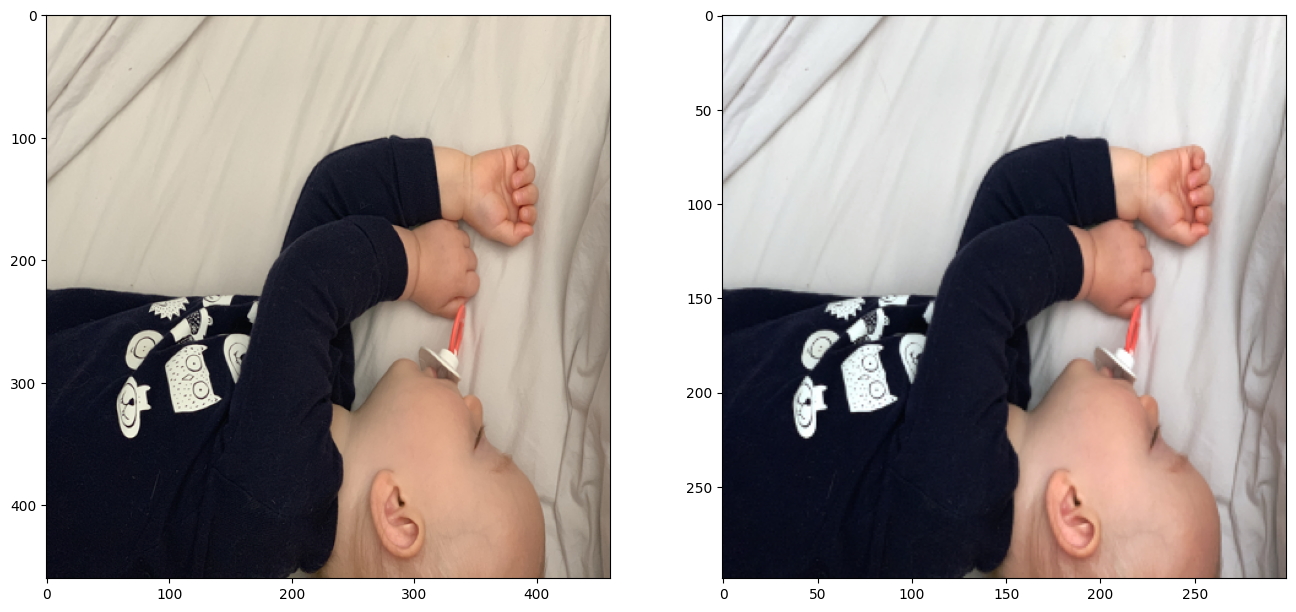

In [53]:
predicted = predict(image_list[img_to_test])
test_image = Image.open(image_list[img_to_test]).downsample()
compare_images((test_image, predicted))

^ This one shows a very good color improvement (to neutral, though).

In [54]:
test_dl = inference_model.dls.test_dl([test_image])
test_dl.after_batch

Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}
 -> sRGBToLinear -> Flip -- {'size': [299, 299], 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}
 -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}

I'll stop here for now.

But the helpers below could be useful for something.

-----

In [55]:
# # Downsample to 460x460, then let the model transforms resize to 224x224
# def params_predict(path):
#     image = Image.open(path).downsample()
#     _ = inference_model.predict(image)
#     # The hook returns params in half-float because that's what the network is using internally
#     # We need float to apply the filters
#     predicted_params = sigHook.sig_outputs[-1].cpu().type(torch.float)
#     return predicted_params
# #     prediction = params_inference_model.predict(image)
# #     return prediction[1]

Predict all test images. In the Mac, this will of course use the CPU. We will create a dataframe and export it to a csv.

In [56]:
# import pandas as pd

# def predict_all(images, prediction_function=params_predict):
#     filter_names = ['temperature', 'ev', 'brightness', 'contrast', 'shadows', 'highlights']
    
#     # Fast df construction: append to dictionaries and create DataFrame later
#     data = {'path': []}
#     for f in filter_names: data[f] = []
    
#     for im_path in images:
#         params = prediction_function(im_path)
#         data['path'].append(im_path)
#         for f, p in zip(filter_names, params):
#             data[f].append(p.item())

#     predictions = pd.DataFrame(data)
#     return predictions

# # transformations.to_csv(path_crappified/'multi_labels.csv', index=False)

In [57]:
# predictions = predict_all(image_list)
# predictions.head(5)

In [58]:
# predictions.to_csv(model_path/'predictions.csv', index=False)

In [59]:
# def model_apply(image_path):
#     image = PILImage.create(image_path).aspect_resize(1280)
#     # The hook returns params in half-float because that's what the network is using internally
#     # We need float to apply the filters
#     params = params_predict(image_path).type(torch.float)
#     display(image)
#     display(apply_to_image(image, params))

In [60]:
# model_apply(image_list[1])

In [61]:
# # Save at 1280 size
# def model_save(image_path, output_dir):
#     "Save original and transformed, both at 1280 size"
#     image = PILImage.create(image_path).aspect_resize(1280)
#     params = params_predict(image_path)
#     transformed = apply_to_image(image, params)
#     output_dir.mkdir(parents=True, exist_ok=True)
#     output_name = (output_dir/(image_path.parent.stem + '_' + image_path.stem + '_out')).with_suffix('.jpg')
#     original_name = (output_dir/(image_path.parent.stem + '_' + image_path.stem)).with_suffix('.jpg')
#     transformed.save(output_name, 'JPEG')
#     image.save(original_name, 'JPEG')
#     print(f'Saved original to {original_name.stem}, transformed to {output_name.stem}')

Save all images to compare them against the ones generated by the Linux notebook. I looked at them and they seem to match.

In [62]:
# output_dir = Path('out_' + model_name)
# for path in image_list: model_save(path, output_dir)